### Quora Competition
https://www.kaggle.com/c/quora-question-intent

In [43]:
from gensim.models import word2vec
import numpy as np
import os
import nltk
import pandas as pd
import re
import time
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)
#nltk.download('stopwords')

In [20]:
STOP_WORDS = nltk.corpus.stopwords.words()

In [36]:
data = pd.read_csv('./data/train.csv').sample(50000, random_state=23)
#data = pd.read_csv('./data/train.csv')
print(data.shape)
data.head()

(50000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,Is sex necessary in a relationship?,Why is sex important in a good relationship?,1
181001,181001,277377,277378,What are the most inspiring start up stories?,What are the most inspirational stories ever?,0
294691,294691,150129,93109,What is your best way to do digital marketing?,What are the best unique ways to do Digital Ma...,1
104145,104145,171986,171987,What is the best way to grow a Facebook fan page?,How do I get more followers on my Facebook page?,1
357893,357893,487310,487311,Suppose Host A sends two TCP segments back to ...,Suppose Host A sends two TCP segments back to ...,1


Training data: 50000
Duplicate pairs: 37.15%
Count of unique question in the training data: 88754
Count of duplicate question: 7397


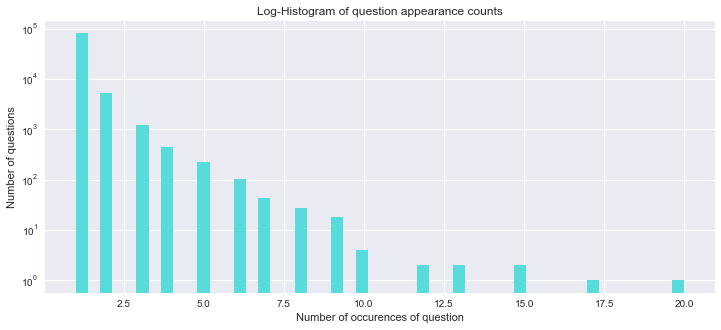

In [44]:
# Number of rows in training data
print('Training data: {}'.format(len(data)))

# Number of rows in testing data
#print('Testing data: {}'.format(len(data)))

# Percentage of duplicate records in training data
print('Duplicate pairs: {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

# Count of unique question from qid1 & qid2
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Count of unique question in the training data: {}'.format(len(
    np.unique(qids))))

# Count of duplicate question from qid1 & qid2
print('Count of duplicate question: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Frequency')
plt.ylabel('Number of questions')
plt.show()

#### Define functions for cleaning sentences and dataframes

In [22]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence


def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

#### Fetch clean data

In [23]:
tic = time.time()
data = clean_dataframe(data)
toc = time.time()
duration = str(round((toc -tic)))
print('Time taken to clean the dataset: '+duration+' Second(s)')
data.head(5)

Time taken to clean the dataset: 27 Second(s)


,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,sex necessary relationship,sex important good relationship,1
181001,181001,277377,277378,inspiring start stories,inspirational stories ever,0
294691,294691,150129,93109,best way digital marketing,best unique ways digital marketing,1
104145,104145,171986,171987,best way grow facebook fan page,get followers facebook page,1
357893,357893,487310,487311,suppose host sends two tcp segments back back ...,suppose host sends two tcp segments back back ...,1


#### prepare gensim-friendly data, that is iterable list of sentences

In [24]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [25]:
corpus = build_corpus(data)        
corpus[0:2]

[['sex', 'necessary', 'relationship'], ['inspiring', 'start', 'stories']]